In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import json
import datetime
import wandb
from tqdm import tqdm
import itertools
from scipy.stats import multivariate_normal


from matplotlib.animation import FuncAnimation

from ssm.util import find_permutation
from pathlib import Path
from hmmlearn import hmm

from ssm.plots import gradient_cmap, white_to_color_cmap

from theoretical_experiment.visual_tools import plot_HMM, plot_Qs, plot_metric

PROJECT_PATH = Path('..')  # .parent
# import sys
# sys.path.insert(1, PROJECT_PATH)
from utils.utils import total_variance_dist
from model.GaussianHMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim

LEARNING_ALGORITHMS = ["em", "cooc"]
T = 10000
np.random.seed(2023)
sns.set_style("white")

wandb_project_name = (
    f"1_GaussianHMM_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')}"
)

### True model

In [2]:
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")  # initialize model from hmmlearn

true_model.startprob_ = np.array([0.6, 0.3, 0.1])
true_model.transmat_ = np.array([[0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.3, 0.3, 0.4]])

true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model.covars_ = (
    np.array(
        [
            [[1, -0.5], [-0.5, 1.2]],
            [[0.6, -0.5], [-0.5, 1.2]],
            [[1.5, 0.5], [0.5, 2.2]],
        ]
    )
    * 0.8
)

true_model.n_features = 2

norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
norms = [norm1, norm2, norm3]

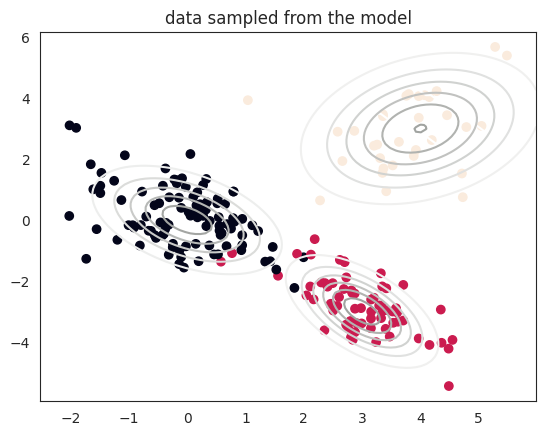

In [3]:
X, Z = true_model.sample(200)


# some things for plotting

x1, y1 = X.min(axis=0) - .5
x2, y2 = X.max(axis=0) + .5

XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

for k in range(true_model.n_components):
    plt.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(sns.xkcd_palette(['grey'])[0]), levels=6)
        
plt.scatter(X[:,  0], X[:, 1], c=Z)
plt.title("data sampled from the model")
plt.show()

In [72]:
model = DiscreteHMM('grid', 400, n_components=3, n_iter=1, 
                    optim_params=dict(max_epoch=10,  lr=0.01))  # parametry dla torcha
model._init(X, None) # init  models parameters, normally it is done in the fit method
model.init_params = '' # do not re-initialize
Xd = model.discretize(X, np.array([X.shape[0]]))

/home/kabalce/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [73]:
lls = np.concatenate([multivariate_normal(model.means_[i], model.covars_[i]).pdf(data).reshape(-1, 1) for i  in range(model.n_components)], axis=1)

fig = plt.figure()

for k in range(true_model.n_components):
    plt.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(sns.xkcd_palette(['grey'])[0]), levels=6)
        
plt.scatter(X[:,  0], X[:, 1], c=Z)
plt.title("data sampled from the model")
plt.show()

<IPython.core.display.Javascript object>

In [74]:
%matplotlib notebook

In [75]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)

cont = ax.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(sns.xkcd_palette(['grey'])[0]), levels=6)

def animate(i):
    lls = np.concatenate([multivariate_normal(model.means_[i], model.covars_[i]).pdf(data).reshape(-1, 1) for i  in range(model.n_components)], axis=1)

    ax.clear()
    ax.scatter(model.nodes[0], model.nodes[1],  marker='x')        
    ax.scatter(X[:,  0], X[:, 1], c=Z)
    for k in range(true_model.n_components):
        cont = ax.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(sns.xkcd_palette(['black'])[0]), levels=6)
    
    ax.scatter(model.means_[:, 0], model.means_[:, 1], marker='*', s=100)
    
    model._fit_cooc(Xd, X, np.array([X.shape[0]]), np.array([X.shape[0]]), False)
    return cont
    
    
ani = FuncAnimation(fig, animate, frames=100, 
                    interval=200, repeat=False)
plt.show()

<IPython.core.display.Javascript object>